### Content

### 1.  Mounting the google drive to google colab

In [ ]:
# mounting the my googledrive to google.colab
# this is needed to save my weights, Neural Network model while it is running
# the model, weights can be accessed at a later time if google colab disconnects

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Standard Imports for Recurrent Neural Networks

In [ ]:
from __future__ import print_function

# For preprocessing the text into integer(ids)
# For plotting the accuracy and loss curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regular expression to proprocess raw_text
import regex as re

# To instantiate Recurrent Neural Networks
from keras.models import Sequential
# My model will be dense with all the nodes to 'touch'
from keras.layers import Dense, Activation
# LSTM, GRU
from keras.layers import LSTM, GRU
#from keras.optimizers import RMSprop, adam

# to create a callback, this will be a checkpoint
from keras.callbacks import LambdaCallback

# need to create a random seed to create a text, so the model will learn the sequence
import random
import sys
import io

### 3. Loading the txt file that is used fro RNN

In [ ]:
# cd to pull my txt file from my google drive into google colab
%cd /content/gdrive/My Drive/Capstone/Data/

# filename called 'out.txt'
filename = "rnn_text.txt"

# extract the raw text
raw_text = open(filename, 'r', encoding='utf-8').read()


# lowercase my text
data = raw_text.lower()
# remove url links
data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',data)
# keep letters
data = re.sub("[^a-zA-Z]", " ", data)
# strip to remove empty spaces before beginning and end of string
data = data.strip()

/content/gdrive/My Drive/Capstone/Data


### 4. Exploring text dataset

In [ ]:
# set - find a list of specific characters 
# list - to convert characters into a list
# sorted - to sort list into alphabetical order
chars = sorted(list(set(data)))

# count of total characters
print('total chars: ', len(chars))

total chars:  27


In [ ]:
# mapping the characters to numerical values & vice versa
# this will be crucial for feeding into our RNN model
# and required to map the predicted numerical values back to their corresponding characters

char_indices = dict((c, i) for i, c in enumerate(chars))

# noted that in this list of character mapping, there is no 'z' in text
# noted that ' ' white space is counted as a character
char_indices

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
# this will be used from mapping numerical values back to characters
indices_char = dict((i, c) for i, c in enumerate(chars))

indices_char

{0: ' ',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

### 5. Numerical encode the sentences and features

In [ ]:
text = data[:10000]

In [ ]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 3300


In [ ]:
print(sentences[:5])
print(next_chars[:5])

['just auditing this course helped me a lot in learning this language programming  attentive save the ', 't auditing this course helped me a lot in learning this language programming  attentive save the mon', 'uditing this course helped me a lot in learning this language programming  attentive save the money ', 'ting this course helped me a lot in learning this language programming  attentive save the money i w', 'g this course helped me a lot in learning this language programming  attentive save the money i will']
['m', 'e', 'i', 'i', ' ']


In [ ]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, shuffle=False)

### 6. define the model topolgy
 https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6

In [ ]:
# Define the model architecture 

def create_model():
    #instantial
    model = Sequential()
    model.add(LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    # Compiling the model
    # as my model are one-hot encoded, i will use categorical_crossentropy
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

#create the model
model_ckpt= create_model()

In [ ]:
model_ckpt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               79872     
_________________________________________________________________
dense (Dense)                (None, 27)                3483      
_________________________________________________________________
activation (Activation)      (None, 27)                0         
Total params: 83,355
Trainable params: 83,355
Non-trainable params: 0
_________________________________________________________________


### 7. Creating my ModelCheckpoint and callback requirements

In [ ]:
from keras.callbacks import ModelCheckpoint

# specifying where my checkpoint files will be stored
filepath = "/content/gdrive/My Drive/Capstone/Data/"

# this ModelCheckpoint save weights and save the best model as it runs
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             save_weights_only=True, save_best_only=True,
                             mode='min',verbose=1 )

In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
### combining all of my callbacks

callbacks = [print_callback, checkpoint, reduce_lr]

### 8.Training my RNN model

In [ ]:
history = model_ckpt.fit(X_train, y_train, batch_size=128, epochs=10, validation_data =(X_test, y_test),callbacks=callbacks)

Epoch 1/10
20/20 [==============================] - 6s 293ms/step - loss: 2.7971 - accuracy: 0.2109 - val_loss: 2.8201 - val_accuracy: 0.2182

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "tions for its proper functioning  the truth is that i die of desire to continue learning more and mo"
tions for its proper functioning  the truth is that i die of desire to continue learning more and mo  e            e                                            e                       e e                  e                                               e      a                                                                         e e     e                            e                                                                                                                  e             
----- diversity: 0.5
----- Generating with seed: "tions for its proper functioning  the truth is that i die of desire to continue learning more and mo"
tions for its p

### 9. evaluating performance of model

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [ ]:
train_Loss, train_Accuracy = model_ckpt.evaluate(X_train, y_train, verbose=2)

78/78 - 2s - loss: 2.4733 - accuracy: 0.2929


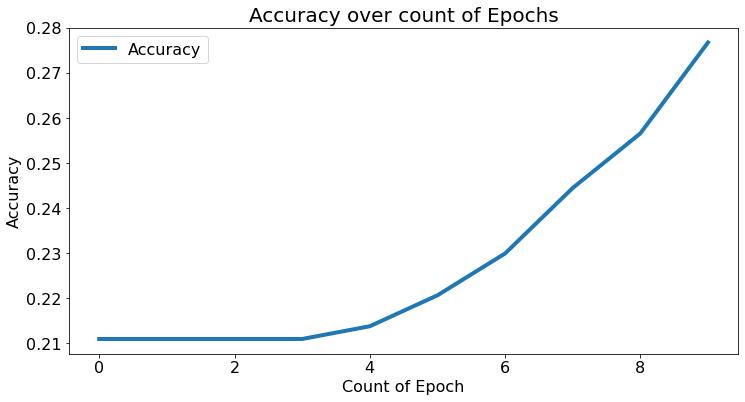

In [ ]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=4)
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


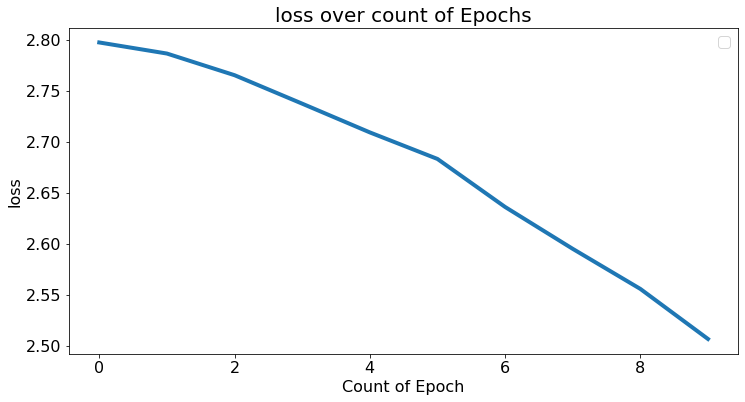

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=4)
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

In [ ]:
test_Loss, test_Accuracy = model_ckpt.evaluate(X_test, y_test, verbose=2)

26/26 - 1s - loss: 2.5557 - accuracy: 0.2691


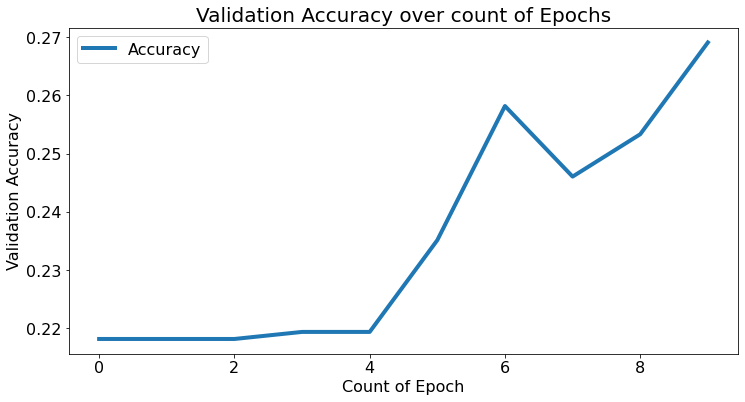

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_accuracy'], label='Accuracy', lw=4)
plt.xlabel('Count of Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over count of Epochs', fontsize=20)
plt.legend();

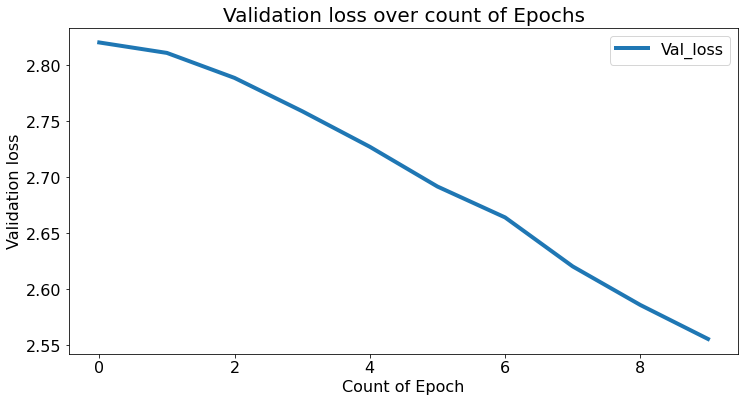

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_loss'], lw=4, label='Val_loss')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss over count of Epochs', fontsize=20)
plt.legend();

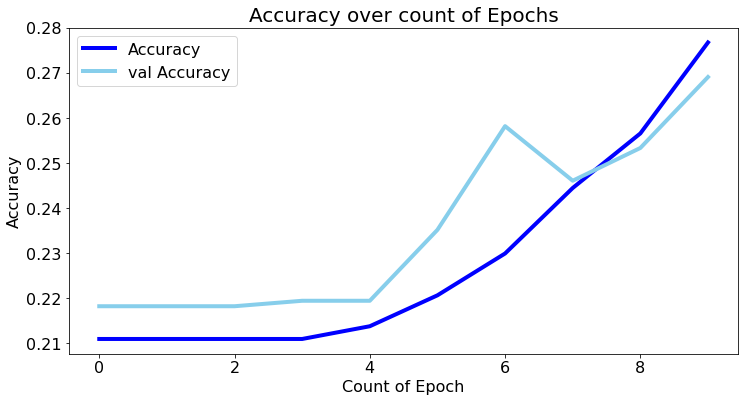

In [ ]:
### Combine both plots

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=4, color='blue')
plt.plot(history.history['val_accuracy'], label='val Accuracy', lw=4, color = 'skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


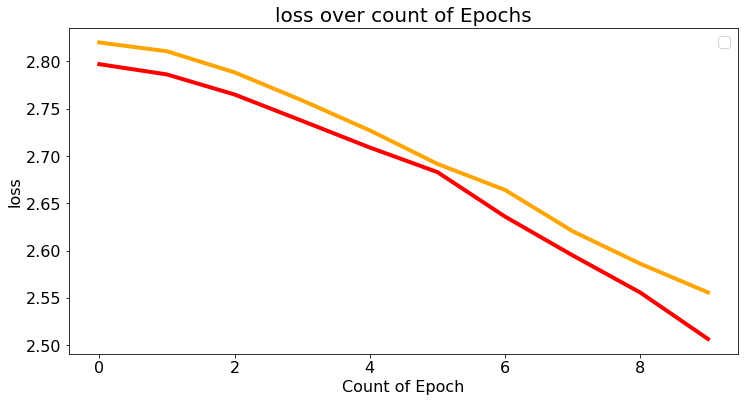

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=4, color='red')
plt.plot(history.history['val_loss'], lw=4, color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

### 10. Loading my pre-trained weights to resume training

In [ ]:
# Instantiate my new model
model_ckpt2 = create_model()

# load the saved weights into my instantiated model
#
model_ckpt2.load_weights(filepath)

In [ ]:
# resume the training

model_ckpt2.fit(X_train, y_train, batch_size=128, epochs=5, validation_data =(X_test, y_test),callbacks=callbacks))

In [ ]:
train_Loss, train_Accuracy = model_ckpt2.evaluate(X_train, y_train, verbose=2)

In [ ]:
test_Loss, test_Accuracy = model_ckpt2.evaluate(X_test, y_test, verbose=2)

### 11.Try generating text using help from keras.io

In [ ]:
### Functions obtained from keras.io to help te
### to help predict the

IndentationError: ignored

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [ ]:
print(generate_text(500, 0.2))

erstand the issue and learn beyond  thanks to the course material chuck  the teacher  is an excellen   ae  tere te   ore te  o  r  re                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   


In [ ]:
print(generate_text(500, 1))

r python courses before  but none had managed to explain the bases in a simple way for people who dissse witmpso ap  le ose yeuacnf colrs ob hetoge  ahe wmexyaolalasr ts  ohleanolpfaalkd ug uo oltd  moohewnsi eplme ts  uufreatiatr yavle tuas  l arer iao kermme vkacrtt d eeuolegrkricg cnhervsiwd ioolss yal  i  orodasic une rlgtk gho resy uxne mberrgyg  here  te inrsra aa stla ne cier lan m t mec ate ledn iembkreedysopmss ooc goire oopqfltlabms rgmiis dg  xoreeortgiapis m ln mene  eod trlnp dnr  tr d ugut t threteyrpron s  free su dshth cie  uau krnt  i ur r ut t ncre tnr sgbillciptfpchs  aoe nx


In [ ]:
print(generate_text(200, 1))

 python courses before  but none had managed to explain the bases in a simple way for people who did uan  ulersiens   asuea tag infd o pre elerdihtrldinsgtokrslown bty  crenowolire  thishcre dd ysmn ror roeteerurltaait tche toe  hbe  rre repwle tw p cehury ts  ntfearerl hfndong  f er lkles awc drfmt
